In [1]:
import torch; torch.manual_seed(0)
import torch.distributions
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import pandas as pd
import ipdb
import os, sys, glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import json
from sklearn.manifold import TSNE
import pathlib
from collections import Counter
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("__file__"), '..')))
from models.vanilla_vae import VanillaVAE
from utils import ProgressMeter, AverageMeter, save_checkpoint, TiffDataset

/home/kangzigi/miniconda3/envs/pixel-ai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# declaring the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 30
batch_size = 4096
lr = 0.0001
latent_dims = 32
hidden_dims = [32, 64, 128, 256, 512]
best_loss_val = 99999999
transform_to_image = T.ToPILImage()
cores_folder = 'TMA_18_810/'
files_path='/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/{0}'.format(cores_folder)
model_path='/data/projects/pixel_project/saved_models'
model_name = "allcores_randompatches"
input_dimensions = (32, 32)

model = VanillaVAE(in_channels=38,latent_dim=latent_dims,input_dimensions=input_dimensions,hidden_dims=hidden_dims).to(device) # GPU
checkpoint = torch.load('{}/vae.pth.tar'.format(model_path))
for key in list(checkpoint['state_dict'].keys()):
    if 'module.' in key:
        checkpoint['state_dict'][key.replace('module.', '')] = checkpoint['state_dict'][key]
        del checkpoint['state_dict'][key]
model.load_state_dict(checkpoint['state_dict'])
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(38, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): S

In [3]:
patches_files = [os.path.join(r, fn)
        for r, ds, fs in os.walk(files_path)
        for fn in fs if fn.endswith('.tiff')]
tiff_dataset = TiffDataset(files=patches_files[0:1000],transform=T.Resize(input_dimensions))

data_loader = torch.utils.data.DataLoader(
    tiff_dataset, batch_size=batch_size, 
    shuffle=None, pin_memory=True, 
    sampler=None
    )

In [4]:
for i, images in enumerate(data_loader):
    images = images.cuda()
    x_hat = model(images)
    loss = model.loss_function(*x_hat, M_N=0.00025)
    z = x_hat[4]
    value = z.cpu().detach().numpy()

In [5]:
np.save('../data/latent_space.npy', value)

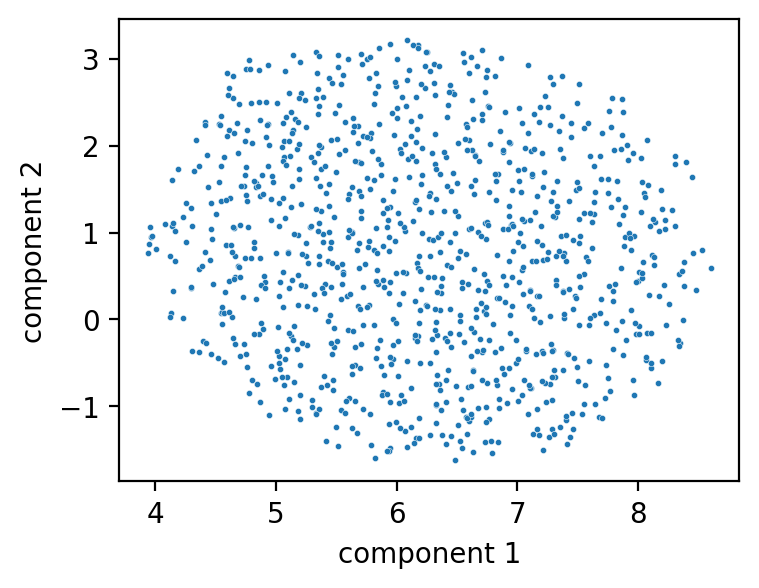

In [23]:
import umap.umap_ as umap

proj_2d = pd.DataFrame(
        data=umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean').fit_transform(value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(4, 3))
sns.scatterplot(data=proj_2d, x="component 1", y="component 2", alpha=1, s=5)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.481638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.999374
[t-SNE] KL divergence after 300 iterations: 2.363849


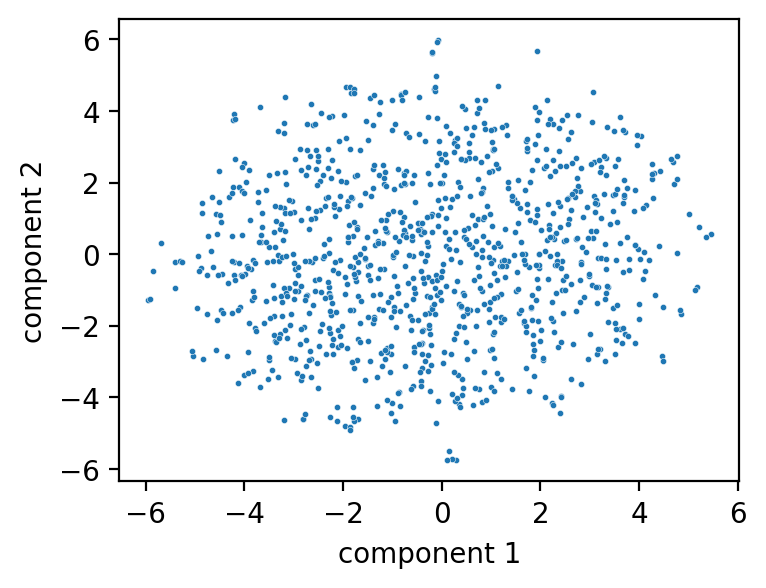

In [25]:
proj_2d_tsne = pd.DataFrame(
        data=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(4, 3))
sns.scatterplot(data=proj_2d_tsne, x="component 1", y="component 2", alpha=1, s=5)
plt.show()